# Scaled LDA v2

_Date:_ October 25, 2024

In [1]:
from collections import namedtuple
from typing import Callable, Optional, Sequence
from jax.typing import ArrayLike
from jax import Array
KeyArray = Array

from functools import partial
import pickle
from tqdm.auto import tqdm

import jax
from jax import jit, grad, lax, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp

import numpy as onp

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.optimize import linear_sum_assignment

from sklearn.decomposition import LatentDirichletAllocation as LDA

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
AutoIntLocator = mpl.ticker.MaxNLocator(nbins='auto', steps=[1,2,5,10], integer=True)

/scratch/users/eyz/miniconda3/envs/dtd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate separable topics
The LDA model implicitly assumes that the underlying latent topics are well-separated.
Sampling from a sparse Dirichlet distribution produces well-separated topics in the asymptotic limit,
but in the (very small) finite regime in which we will simulate data (i.e. $\mathcal{O}(K) = 10$),
there is no guarantee that the topics we generate satisfy this assumption.

We can generate well-seperated topics through an acceptance-rejection scheme.
Specifically, for a target $K$ topics, we will generate $\tilde{K} \gg K$ topics,
then select the $K$ subset that maximizes pairwise distance.

### Topic dissimilarity metrics

Cosine distance is used to evaluate topic dissimilarity (see Cao et al. 2009), where
\begin{equation}
D_\textrm{cosine}(\mathbf{p},\mathbf{q}) = 1 - \frac{\mathbf{p}\cdot\mathbf{q}}{\Vert \mathbf{p} \Vert_2 \Vert \mathbf{q} \Vert_2 }.
\end{equation}
where $\mathbf{p} \in \mathbb{R}^d, \mathbf{q} \in \mathbb{R}^d$ are two $d$-dimensional vectors. In our case of interest, they are specifically two vectors on the simplex $\mathbf{p} \in \Delta_d, \mathbf{q} \in \Delta_d$.

The Hellinger distance for the Dirichlet distribution was also considered
(see: _"Probabilistic distance measures of the Dirichlet and Beta distributions." (2008) [[link]](https://www.sciencedirect.com/science/article/pii/S0031320307003123)_)
but the exact application does not seem to work well for single samples (it was designed for distributions...).
The same paper above discusses why the KL divergence is not defined for the Dirichlet distributions, and therefore why it is inappropriate.

One question is why we can apply the KL divergence to samples of distributions, whereas we cannot apply the Hellinger distance to samples of the Dirichlet distribution. Mathematically, I can see why the metric is measuring samples to be much more similar than they truly are, but I'm not sure why we can use the KL divergence on individual samples and no the Hellinger distance. This will be a good question to ask the in-the-weeds channel.

See `2024-10-10-Scaled-LDA-EM-PGD.ipynb` for empirical exploration of generating separable topics and evaluating distance measures on Dirichlet samples.

In [2]:
def cosine_dist(u, v):
    """Compute cosine distance between two vectors of same length."""

    return 1 - jnp.dot(u, v) / jnp.sqrt(jnp.sum(u**2)) / jnp.sqrt(jnp.sum(v**2))

def pdist_jax(arr, fn, return_mat: bool=False):
    """Pairwise distances between observations. JAX implementations of `scipy.spatial.distances.pdist`

    Parameters
        arr: shape (N,D). Array of N observations in a D-dimensional space.
        fn: Callable. Distance function taking in two vectors of same length.
        return_mat: bool. If True, return a dense (N,N) distance matrix.
            Default: False, return the distance matrix as a condensed vector,
            of the upper triangular elements, length (N*(N-1)/2).
    
    Returns
        dists: shape (N,N) if return_mat else (N * (N-1)/2,).

    """

    mat = vmap(vmap(fn, in_axes=(0,None)), in_axes=(None,0))(arr, arr)

    if return_mat:
        return mat
    else:
        i, j = jnp.triu_indices_from(mat, 1)
        return mat.at[i,j].get()

### Procedure

Our approach is inspired by the data-generating process used by Bystrov et al. (2024). While they generate datasets by first inferring topics and weights from real document corpora (neat idea!), we simply generate synthetic topics and weights. We follow their approach in generating a superset of draws from a Dirichlet distribution, then evaluate their pairwise distances to choose a subset of topics that maximize distance.

Suppose we are interested in generating $N$ Dirichlet distributed topics. We define a minimum distance that all pairs of seleted topics must be from each other $c \in [0,1]$. Then,
1. Sample $X_i \overset{iid}{\sim} \textrm{Dir}(\alpha)$ for $i=1,\ldots,\tilde{N}$, where $\tilde{N} \gg N$.
2. Compute the pairwise distances $C(X_i,X_{i'})$ between all samples; this results in ${\tilde{N}\choose{2}} =\left(\tilde{N}(\tilde{N}-1)\right)/2$ distances.
3. Initialize the set of selected topics with the two topics with maximal pairwise distances, $Y^{(0)} = \{X_i, X_j\}$ where $(X_i, X_j) = \arg\max C(X_i,X_j)$. Track the selected topic indices, $\mathcal{J}=\{i,j\}$

    - Alternatively, we could seed the initial two topics probabilitistically, by choosing a sample pair with probability $\frac{C_k}{\sum_{k'\in \mathcal{K}C_{k'}}}$ where $\mathcal{K} = \{1, \ldots,  {\tilde{N}\choose 2}\}$.
4. While $|Y| < N$, iterate through the remaining unselected topics: 
If $C(i,j) \geq c$ for $i \in \mathcal{K}\backslash\mathcal{J}$ and for **all** $j \in \mathcal{J}$, then $Y \leftarrow Y \cup \{X_i\}$ and $\mathcal{J} \leftarrow \mathcal{J} \cup \{i\}$

5. Return $Y$.

Note that this algorithm is not guaranteed to be optimal in the sense of globally maximizing distances while all distances lie above some threshold.
It also does not guarantee that $N$ topics will be found. However, we use this algorithm because it is easy to implement. It may require some tuning of the threshold value.

**A more optimal solution (future work)**
A more optimal formulation is to find the $N$ subset of $\tilde{N}$ samples that respects the threshold conditions.
\begin{align*}
\textrm{maximize} \quad& \sum_{i,j\in\mathcal{J}, i\neq j} C(i,j) \\
\textrm{s.t. } \quad & C(i,j) \geq \; c \quad \textrm{for } i,j\in\mathcal{J}, i\neq j \\
& \vert\mathcal{J}\vert = N
\end{align*}
This should be a simplified version of the "knapsack" problem and _may_ be solved via some sort of convex optimization.

In [3]:
def generate_separable_dirichlet_samples(
    key: KeyArray,
    dim: int,
    n_samples: int,
    conc: float | Array,
    dist_fn: Callable[[Array,Array], float]=cosine_dist,
    threshold: float=None,
    n_simulated: int=None,
    ):
    """Generate seperable samples from a Dirichlet distribution.

    All samples must have a pairwise distance >= threshold, as defined by the distance_fn.

    Note! This user does not necessarily find `n_samples` that satisfy the conditions;
    topics that are not found will be a vector of 0's. Users must manually check that
    all topics have been found, e.g. `jnp.allclose(selected_topics.sum(axis=-1), 1)`.

    This function uses a for loop, which is much easier to read than a JAX scan and generally
    faster, especially for the number of samples we are looking to generate. For JAX scan
    implementation, check out the function of the same name in the 2024-10-03 notebook.

    Parameters
        key: PRNG key
        n_samples: int. Number of samples to return.
        dim: int. Dimensionality of the vectors
        conc: Concentration of Dirichlet distribution. Must be broadcastable to (dim,).
        dist_fn: Callable. Distance metric to compute separability. Default: cosine_dist
        threshold: float. Distance threshold between all topics. Value in range of dist_fn.
            If None (default), set to 90% percentile of pairwise distances in simulated samples.
        n_simulated: int. Total number of samples to simulate, should be >>n_samples
            so that we can reject samples. If None (default), set to 50*n_samples
    
    Returns
        selected_topics: shape (n_samples, dim)
            NOTE: This function does not throw an error. User must manually check that
            `jnp.allclose(selected_topics.sum(axis=-1), 1).`
        sorted_dists: shape (n_simulated*(n_simulated-1)/2,)
            All pairwise distances in the simulated samples. Used for post-hoc analysis
            of distribution parameters and threshold
        threshold: float. Distance thresholding value.
    """
    if n_simulated is None:
        n_simulated = 50 * n_samples

    conc = jnp.broadcast_to(jnp.asarray(conc, dtype=float), (dim,),)
    samples = jr.dirichlet(key, conc, (n_simulated,))  # shape (N_sim, D)

    # Calculate the pairwise distances b/t samples; sort from largest to smallest dists
    dists = pdist_jax(samples, dist_fn)  # shape P_sim := (N_sim * (N_sim-1)/2)
    sorted_dist_idxs = jnp.argsort(dists, descending=True)  # largest to smallest distances
    sorted_dists = dists[sorted_dist_idxs]

    # Set threshold, if not provided
    if threshold is None:
        threshold = jnp.percentile(dists, 10)

    # Get the sample indices, sorted by greatest pairwise distances
    ijs = jnp.stack(jnp.triu_indices(n_simulated, 1), axis=-1)  # shape (N2_sim, 2)
    ijs = ijs[sorted_dist_idxs].ravel()  # shape (B2_sim * 2)
    _, unique_sample_id_idxs = jnp.unique(ijs, return_index=True)
    sorted_sample_ids = ijs[jnp.sort(unique_sample_id_idxs)]

    # Initialize with the greatest pairwise-separable topics
    selected_samples = jnp.zeros((n_samples, dim))
    selected_samples = selected_samples.at[:2].set(samples[sorted_sample_ids[:2]])
    n_selected = 2

    for i, idx in enumerate(sorted_sample_ids[2:]):
        proposed_samples = selected_samples.at[n_selected].set(samples[idx])
        
        tmp = pdist_jax(proposed_samples[:n_selected+1], dist_fn)
        if all(tmp >= threshold):
            selected_samples = proposed_samples
            n_selected += 1

        if (n_selected >= n_samples):
            break
    
    return selected_samples, sorted_dists, threshold

In [4]:
key = jr.key(0)
dim, conc = 30, 0.2
n_samples, n_simulated = 10, 500
dist_fn, threshold = cosine_dist, 0.6

n_examples = 10

all_naive_samples, all_selected_samples = [], []
for i in range(n_examples):
    this_key = jr.fold_in(key, i)
    
    naive_samples, _, _ = generate_separable_dirichlet_samples(
        this_key, dim=dim, conc=conc, n_samples=n_samples, dist_fn=dist_fn, threshold=0, n_simulated=n_samples,
    )  # we reuse the custom function to generate naively; 

    selected_samples, _, _ = generate_separable_dirichlet_samples(
        this_key, dim=dim, conc=conc, n_samples=n_samples, dist_fn=dist_fn, threshold=0.6, n_simulated=n_simulated,
    )

    if not jnp.allclose(selected_samples.sum(axis=-1), 1, atol=0, rtol=1e-1):
        print(f"example {i}: topics not all filled", )

    all_naive_samples.append(naive_samples)
    all_selected_samples.append(selected_samples)

2024-10-28 18:07:48.548238: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


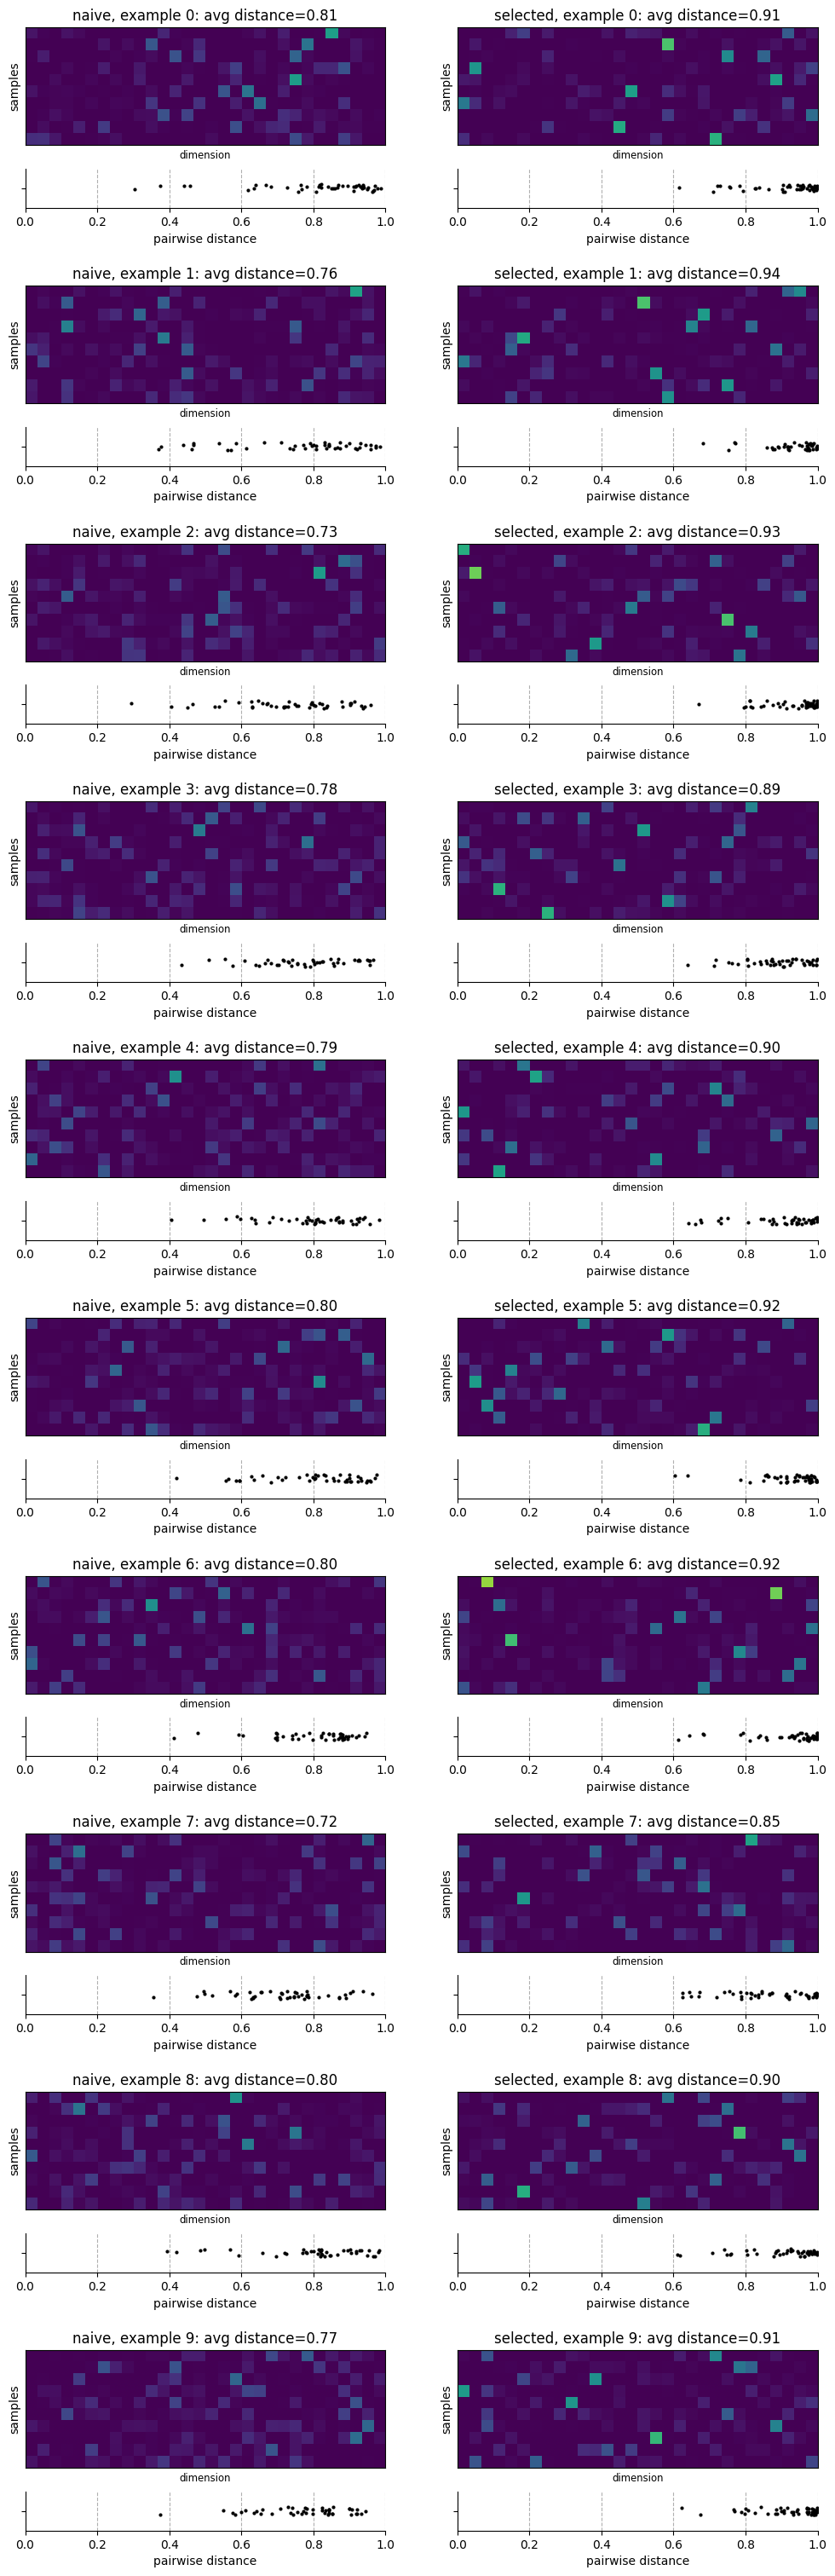

In [5]:
vmax = 1

fig = plt.figure(figsize=(12, n_examples*3))
subfigs = fig.subfigures(nrows=n_examples, ncols=1, hspace=0.1)

for i_example, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=2, ncols=2, height_ratios=[3,1], gridspec_kw={'hspace': 0.3})

    for i_subcol, samples in enumerate([all_naive_samples[i_example], all_selected_samples[i_example]]):
        dists = pdist_jax(samples, dist_fn)

        # First row: plot samples
        ax = axs[0, i_subcol]
        ax.imshow(samples, vmin=0, vmax=vmax, interpolation='none', aspect='auto')
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
        ax.set_xlabel('dimension', fontsize='small')
        ax.set_ylabel('samples')
        ax.set_title(f"{['naive', 'selected'][i_subcol]}, example {i_example}: avg distance={dists.mean():.2f}")
        
        # Second row: swarm plot fo dists
        ax = axs[1, i_subcol]
        sns.stripplot(data=dists, orient='h', color='k', size=6, marker='.', ax=ax)
        ax.set_xlabel('pairwise distance'); ax.set_xlim(0,1)
        ax.grid(axis='x', ls='--')
        ax.set_title(f'')
        sns.despine(ax=ax)


### Generate scaled LDA

Now, we randomly generate the parameters of our scaled LDA model. We denote the above procedure $\textrm{SeparatedDir}(\alpha)$ to clearly indicate our data-generating process.

In [6]:
key = jr.key(1010110)
topics_key, scales_key, weights_and_data_key = jr.split(key, 3)

**Sample topics**

Text(0.5, 1.0, 'topic-vocab distributions')

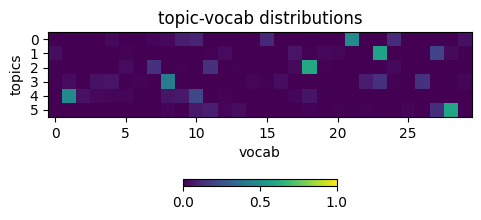

In [7]:
vocab_size = 30
n_topics = 6
topic_conc = 0.2

topics, *_ = generate_separable_dirichlet_samples(
    topics_key, dim=vocab_size, conc=topic_conc, n_samples=n_topics, dist_fn=cosine_dist, threshold=0.6,
)
assert jnp.allclose(topics.sum(axis=-1), 1, atol=0, rtol=1e-3)


# -----------------------------------------------------------------------------------------------------

topics_vmax = 1

plt.figure(figsize=(6,2))
ax = plt.gca()

im = ax.imshow(topics, vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
plt.colorbar(
    im, ax=ax, fraction=0.05, extend='max' if topics_vmax < 1 else 'neither',
    orientation='horizontal', pad=0.4,
)
ax.set_ylabel('topics'); ax.set_yticks(range(n_topics))
ax.set_xlabel('vocab')
ax.set_title('topic-vocab distributions', fontsize='large')

**Sample per-document parameters**

In [8]:
n_docs = 5000
doc_length_rate = 1000
weights_conc = 1.0

# Sample doc-word scales from a range of shapes
gamma_params = jnp.array([1e-1, 1e0, 1e1, 1e3])  # let's vary the Gamma distribution shape (and scale)

gammas_by_shape = vmap(
    lambda key, shape: shape * jr.gamma(this_key, shape, (n_docs, vocab_size))
)(jr.split(scales_key, len(gamma_params)), gamma_params)  # shape (n_concs, vocab_size)

In [9]:
def sample_weights_and_data(
    key: KeyArray, topics: Array, gammas: Array, n_docs: int, doc_length_rate: float, weights_conc: float=1.0
):
    """Sample document-topics and data from a scaled LDA model."""

    weights_key, lengths_key, data_key = jr.split(key, 3)

    n_topics, vocab_size = topics.shape

    # Sample document-topic weights, shape (n_docs, n_topics)
    weights_conc_ = jnp.broadcast_to(jnp.asarray(weights_conc, dtype=float), (n_topics,))
    weights = jr.dirichlet(weights_key, weights_conc_, (n_docs,))

    # Sample document lengths, shape (n_docs,)
    lengths = jr.poisson(lengths_key, doc_length_rate, (n_docs,))
    lengths = jnp.asarray(lengths, dtype=float)  # convert to float for tfd.Multinomial

    # Sample data, shape (n_docs, vocab_size)
    probs = gammas * (weights @ topics)
    probs /= probs.sum(axis=-1, keepdims=True)
    data = tfd.Multinomial(lengths, probs=probs).sample((), data_key)

    return weights, data
    
# weights_by_shape: shape (n_shapes, n_docs, n_topics)
# data_by_shape: shape (n_shapes, n_docs, vocab_size)
weights_by_shape, data_by_shape = vmap(
    lambda gammas: sample_weights_and_data(
        weights_and_data_key, topics, gammas, n_docs, doc_length_rate, weights_conc
    )
)(gammas_by_shape)

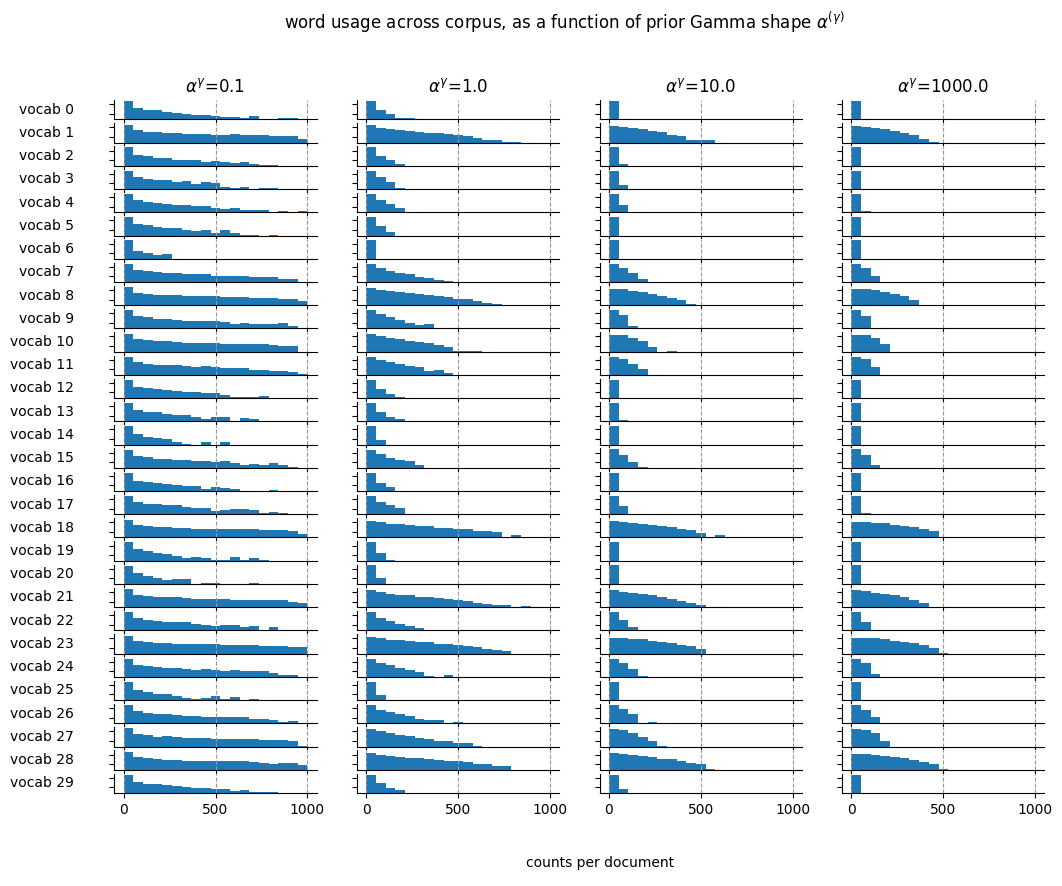

In [10]:
nrows = vocab_size
ncols = len(gamma_params)

# Share bins
n_bins = 20
bin_edges = onp.linspace(0, doc_length_rate, num=n_bins)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(12,9))

for i, gamma_shape in enumerate(gamma_params):
    axs[0,i].set_title(rf"$\alpha^\gamma$={gamma_shape:.1f}", fontsize='large')

    for v in range(vocab_size):
        ax = axs[v,i]
        ax.hist(data_by_shape[i,:,v], bin_edges, histtype='stepfilled')

        # Set y-axis to LOG scale so that we can see the heavy tails.
        ax.set_yscale('log')

        ax.grid(True, axis='x', color='0.6', ls='--')


for v, ax in enumerate(axs[:,0]):  # first column: label rows with word id, label y-axis
    # ax.set_ylabel("#", fontsize='small')
    ax.tick_params(labelleft=False)
    ax.text(-0.2, 0.5, f"vocab {v}", transform=ax.transAxes, ha='right', va='center', fontsize='medium')

# bottom row: shared x-axis label
plt.text(0.5, 0.01, f"counts per document", transform=subfigs[2].transFigure, ha='center', va='top', fontsize='medium')

# set title
fig.suptitle(r'word usage across corpus, as a function of prior Gamma shape $\alpha^{(\gamma)}$')

sns.despine()

We see that as $\alpha^{(\gamma)} \rightarrow \infty$, $\gamma_{mv}\rightarrow 1$, and the word usage spread decreases $\mathbb{V}[X_v] \downarrow$.

## Inference under standard LDA model

Here, we use the variational Bayes algorithm for inferring parameters in a standard LDA model, as implemented by sklearn.

In [11]:
def multinomial_ll(data, topics, weights, scales, scounts=None):
    """Compute multinomial LL of data given model params."""

    probs = scales * (weights @ topics)
    probs /= probs.sum(axis=-1, keepdims=True)

    return tfd.Multinomial(data.sum(axis=-1), probs=probs).log_prob(data)

### Standard LDA case: $\alpha^{\gamma}_v \rightarrow \infty$

Here, we sanity check that in the limiting case of $\alpha^{\gamma}_v \rightarrow \infty$ for all $v \in 1,\ldots,V$, the data generated is as if it was generated under a standard LDA model, and the corresponding VB algorithm can recover the topics perfectly.

In [12]:
# Shape hyperparameter of (1D) Gamma-distributed scale, shape (V,)
gamma_shapes = 1e3 * jnp.ones(vocab_size)

# Scale parameter, shape (M,V)
gammas = gamma_shapes * jr.gamma(scales_key, gamma_shapes, (n_docs, vocab_size))

# Topic weights and data
# weights: shape (n_docs, n_topics)
# data: shape (n_docs, vocab_size)
weights, data = sample_weights_and_data(
    weights_and_data_key, topics, gammas, n_docs, doc_length_rate, weights_conc
)

true_params = dict(
    topics = topics, 
    weights = weights,
    gammas = gammas,
)

In [13]:
standard_data = data  # let's save the data from the standard case for reference

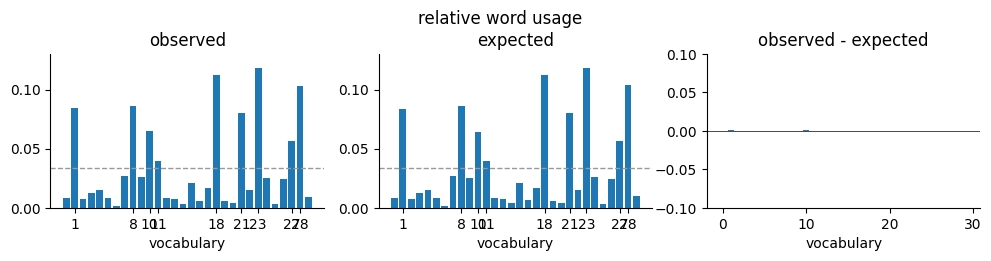

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,2))

data_rel_usage = data.sum(axis=0) / data.sum()
topics_rel_usage = topics.sum(axis=0) / topics.sum()
ylim = onp.max([data_rel_usage, topics_rel_usage])
for ax, arr, title in zip(axs, [data_rel_usage, topics_rel_usage], ['observed', 'expected']):
    ax.bar(range(vocab_size), arr)
    ax.set_title(title)
    ax.set_xlabel('vocabulary')
    ax.set_ylim(0, 1.1*ylim)

    threshold = 1 / vocab_size
    xticks = onp.nonzero(arr >= threshold)[0]
    ax.set_xticks(xticks); ax.set_xticklabels(xticks)
    ax.axhline(threshold, color='0.6', ls='--', lw=1)

# Show differences in usage
ax = axs[-1]
diff = data_rel_usage - topics_rel_usage
ax.bar(range(vocab_size), diff)

# adjust ylims so that they are not too small
ymin, ymax = ax.get_ylim()
ax.set_ylim(onp.minimum(ymin, -0.1), onp.maximum(ymax, 0.1))

ax.set_title('observed - expected')
ax.set_xlabel('vocabulary')
ax.axhline(0, color='k', lw=0.5)

fig.suptitle('relative word usage', y=1.1)
sns.despine()

The empirical word usage across the corpus is the same as the relative word usage across the topics,
suggesting that this data is indeed similar to a standard LDA model.

In [15]:
n_inits = 2
n_topics = 6

all_topics, all_weights, all_lls = [], [], []
for _ in range(n_inits):
    lda = LDA(n_topics)
    weights = lda.fit_transform(data)
    topics = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
    
    scales = jnp.ones(vocab_size)/vocab_size  # In standard lda model, scales are just uniform 1/V

    lls = multinomial_ll(data, topics, weights, scales).mean()

    all_topics.append(topics)
    all_weights.append(weights)
    all_lls.append(lls)

all_topics = onp.asarray(all_topics)
all_weights = onp.asarray(all_weights)
all_lls = onp.asarray(all_lls)

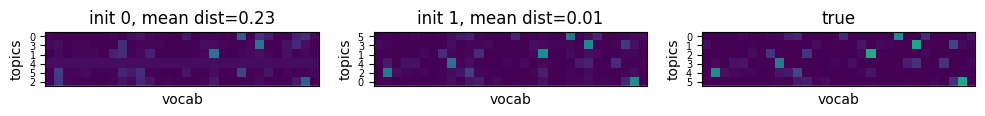

In [16]:
topics_vmax = 1

fig, axs = plt.subplots(nrows=1, ncols=n_inits+1, figsize=(12,6))

dict_of_things = {
    **{f"init {i}": all_topics[i] for i in range(n_inits)},
    "true": true_params['topics']
}

for ax, (name, topics) in zip(axs, dict_of_things.items()):
    # Find the best permutation
    if name != "true":
        cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
        _, i_sorted = linear_sum_assignment(cost_matrix)
        i_discarded = onp.nonzero(onp.isin(onp.arange(len(topics)), i_sorted, invert=True))[0]
        i_permute = onp.concatenate([i_sorted, i_discarded])
        
        final_cost = onp.diag(cost_matrix[:,i_sorted]).mean()
        ax.set_title(f"{name}, mean dist={final_cost:.2f}")
    else:
        i_sorted = i_permute = onp.arange(len(topics))
        ax.set_title(name)

    im = ax.imshow(topics[i_permute], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
    
    # Draw line to indicate the topics below which have been discarded
    ax.axhline(len(i_sorted)-0.5, color='w', lw=1)

    # Label topics by their original ordering
    ax.set_yticks(onp.arange(len(topics))); ax.set_yticklabels(i_permute)
    
    ax.set_ylabel('topics')
    ax.set_xlabel('vocab'); ax.tick_params(bottom=False, labelbottom=False, labelsize='x-small')
    

Indeed, the standard LDA VB algorithm recovers the true topics. We are sane.

### Overdispersed case

Now, let's consider the other extreme, where all words are overdispersed, $\alpha^{\gamma}_v \rightarrow 0$ for all $v \in 1,\ldots,V$.

However, the words are all similarly overdispersed. So, we expect the VB algorithm to still do fairly okay!

In [41]:
# Shape hyperparameter of (1D) Gamma-distributed scale, shape (V,)
gamma_shapes = 1e-1 * jnp.ones(vocab_size)

# Scale parameter, shape (M,V)
gammas = gamma_shapes * jr.gamma(scales_key, gamma_shapes, (n_docs, vocab_size))

# Topic weights and data
# weights: shape (n_docs, n_topics)
# data: shape (n_docs, vocab_size)
weights, data = sample_weights_and_data(
    weights_and_data_key, topics, gammas, n_docs, doc_length_rate, weights_conc
)

true_params = dict(
    topics = topics, 
    weights = weights,
    gammas = gammas,
)

Text(0.5, 1.0, 'prior scales')

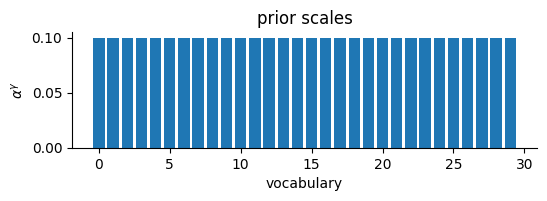

In [45]:
plt.figure(figsize=(6,1.5))

ax = plt.gca()
ax.bar(range(vocab_size), gamma_shapes)
ax.set_ylim(0)
sns.despine()
ax.set_xlabel('vocabulary')
ax.set_ylabel(r'$\alpha^\gamma$')
ax.set_title('prior scales')

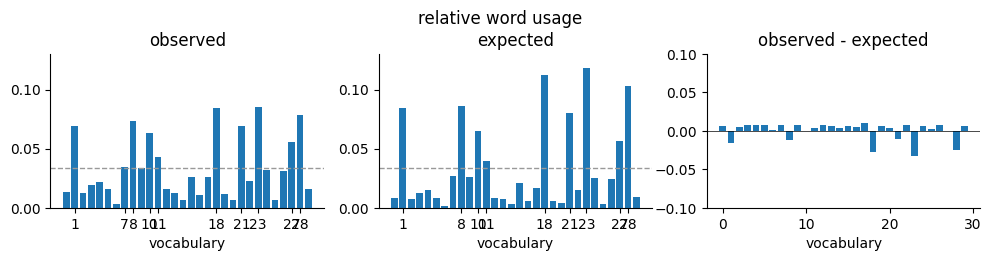

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,2))

data_rel_usage = data.sum(axis=0) / data.sum()
topics_rel_usage = standard_data.sum(axis=0) / standard_data.sum()
ylim = onp.max([data_rel_usage, topics_rel_usage])
for ax, arr, title in zip(axs, [data_rel_usage, topics_rel_usage], ['observed', 'expected']):
    ax.bar(range(vocab_size), arr)
    ax.set_title(title)
    ax.set_xlabel('vocabulary')
    ax.set_ylim(0, 1.1*ylim)

    threshold = 1 / vocab_size
    xticks = onp.nonzero(arr >= threshold)[0]
    ax.set_xticks(xticks); ax.set_xticklabels(xticks)
    ax.axhline(threshold, color='0.6', ls='--', lw=1)

# Show differences in usage
ax = axs[-1]
diff = data_rel_usage - topics_rel_usage
ax.bar(range(vocab_size), diff)

# adjust ylims so that they are not too small
ymin, ymax = ax.get_ylim()
ax.set_ylim(onp.minimum(ymin, -0.1), onp.maximum(ymax, 0.1))

ax.set_title('observed - expected')
ax.set_xlabel('vocabulary')
ax.axhline(0, color='k', lw=0.5)

fig.suptitle('relative word usage', y=1.1)
sns.despine()

We see some greater greater differences in relative word usage.
Interestingly, when rate parameters induce much greater dispersion of word usage, but that dispersion is the same the relative word usages are still very similar (but not exactly the same) as the word usage by the latent topics.

One way we can think of this is as the word scales $(\gamma_1, \ldots, \gamma_v)$ being Dirichlet distributed (since they all share the same Gamma rate parameter under our formulation).

Thus, we expect the VB algorithm to recover the true topics fairly well.

Text(0.5, 0.95, 'observed word usage')

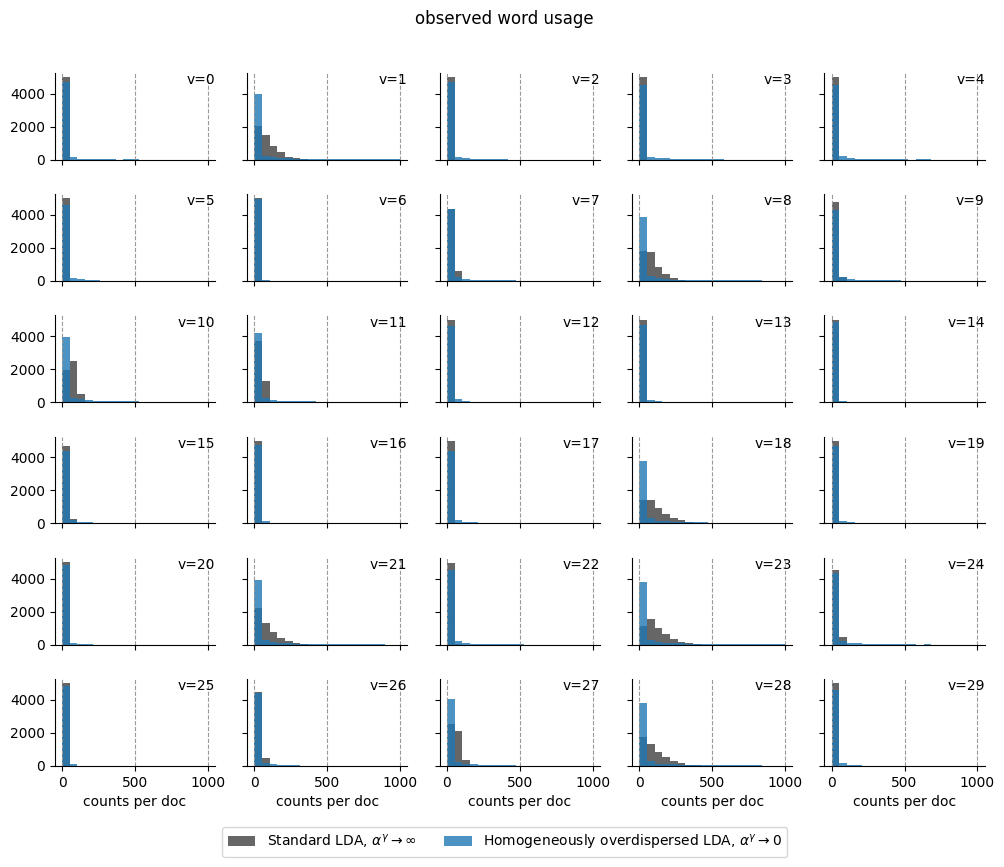

In [54]:
ncols = 5
nrows = (vocab_size // ncols) + (vocab_size % ncols > 0)

# Share bins
n_bins = 20
bin_edges = onp.linspace(0, doc_length_rate, num=n_bins)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(12,9),
    gridspec_kw={'hspace': 0.4},
)

for v, ax in enumerate(axs.ravel()):
    # Plot the data generated from a standard LDA
    ax.hist(
        standard_data[:,v], bin_edges, histtype='stepfilled',
        label=r'Standard LDA, $\alpha^\gamma \rightarrow \infty$',
        color = '0.4'
    )

    # Plot this data
    ax.hist(
        data[:,v], bin_edges, histtype='stepfilled',
        label=r'Homogeneously overdispersed LDA, $\alpha^\gamma \rightarrow 0$',
        fc='C0', alpha=0.8
    )

    # Set y-axis to LOG scale so that we can see the heavy tails.
    # ax.set_yscale('log')

    ax.grid(True, axis='x', color='0.6', ls='--')

    ax.text(1, 1, f"{v=}", ha='right', va='top', transform=ax.transAxes)

for ax in axs[-1,:]:
    ax.set_xlabel('counts per doc')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], bbox_to_anchor=[0.5, 0.05], loc='upper center', ncols=2)
sns.despine()

fig.suptitle('observed word usage', y=0.95)



In [57]:
n_inits = 2
n_topics = 10

all_topics, all_weights, all_lls = [], [], []
for _ in range(n_inits):
    lda = LDA(n_topics)
    weights = lda.fit_transform(data)
    topics = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
    
    scales = jnp.ones(vocab_size)/vocab_size  # In standard lda model, scales are just uniform 1/V

    lls = multinomial_ll(data, topics, weights, scales).mean()

    all_topics.append(topics)
    all_weights.append(weights)
    all_lls.append(lls)

all_topics = onp.asarray(all_topics)
all_weights = onp.asarray(all_weights)
all_lls = onp.asarray(all_lls)

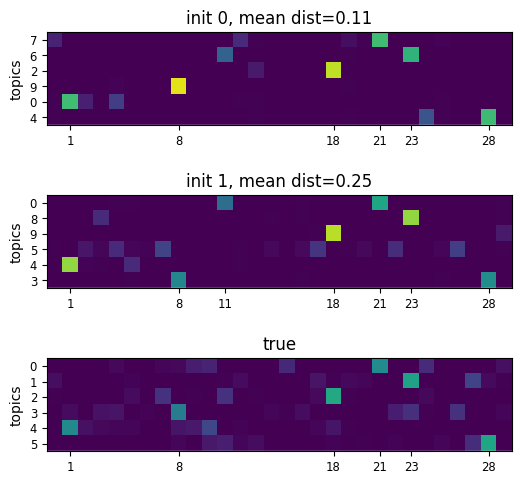

In [58]:
topics_vmax = 1

# fig, axs = plt.subplots(nrows=1, ncols=n_inits+1, figsize=(12,6))
fig, axs = plt.subplots(ncols=1, nrows=n_inits+1, figsize=(6,6))

dict_of_things = {
    **{f"init {i}": all_topics[i] for i in range(n_inits)},
    "true": true_params['topics']
}

for ax, (name, topics) in zip(axs, dict_of_things.items()):
    # Find the best permutation
    if name != "true":
        cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
        _, i_sorted = linear_sum_assignment(cost_matrix)
        i_discarded = onp.nonzero(onp.isin(onp.arange(len(topics)), i_sorted, invert=True))[0]
        # i_permute = onp.concatenate([i_sorted, i_discarded]) # no need to show discarded ones
        i_permute = i_sorted
        
        final_cost = onp.diag(cost_matrix[:,i_sorted]).mean()
        ax.set_title(f"{name}, mean dist={final_cost:.2f}")
    else:
        i_sorted = i_permute = onp.arange(len(topics))
        ax.set_title(name)

    im = ax.imshow(topics[i_permute], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
    
    # Draw line to indicate the topics below which have been discarded
    ax.axhline(len(i_sorted)-0.5, color='w', lw=1)

    # Label topics by their original ordering
    ax.set_yticks(onp.arange(len(i_permute))); ax.set_yticklabels(i_permute)
    
    # Label the words that have "high" weight
    threshold = 10. / vocab_size
    xticks = onp.nonzero(onp.max(topics[i_permute][:len(i_sorted)], axis=0) >= threshold)[0]
    ax.set_xticks(xticks); ax.set_xticklabels(xticks)
    ax.tick_params(labelsize='small')
    # ax.tick_params(bottom=False, labelbottom=False)  # don't show any ticks


    ax.set_ylabel('topics')
    # ax.set_xlabel('vocab')    

Words with a topic usage greater than 10x change (i.e. $10/V$) are indicated in the x-axis.

Indeed, the model is able to recover the topics fairly well, although the topics are inferred to be much sparser than they are.

### Non-homogeneous dispersion, $0 \ll \alpha^{\gamma}_v < \infty$

Now, we vary the dispersion hyperparameter over words, such $\alpha^{\gamma}_v$ is not the same for all $v$. I expect the inferred parameters to begin exhibiting the pathology of many topics placing high concentration on the same highly observed words.

We will sample $\alpha^{\gamma}_v \sim \textrm{Uniform}(1e1, 1e3)$.

In [73]:
scales_key_0, scales_key_1 = jr.split(scales_key)
gamma_shapes = jr.uniform(scales_key_0, (vocab_size,), minval=1e-1, maxval=1e3)

gammas = gamma_shapes * jr.gamma(scales_key_1, gamma_shapes, (n_docs, vocab_size))

# Topic weights and data
# weights: shape (n_docs, n_topics)
# data: shape (n_docs, vocab_size)
weights, data = sample_weights_and_data(
    weights_and_data_key, topics, gammas, n_docs, doc_length_rate, weights_conc
)

true_params = dict(
    topics = topics, 
    weights = weights,
    gammas = gammas,
)

Text(0.5, 1.0, 'prior scales')

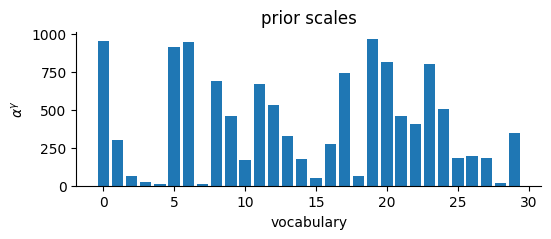

In [74]:
plt.figure(figsize=(6,2))

ax = plt.gca()
ax.bar(range(vocab_size), gamma_shapes)
ax.set_ylim(0)
sns.despine()
ax.set_xlabel('vocabulary')
ax.set_ylabel(r'$\alpha^\gamma$')
ax.set_title('prior scales')

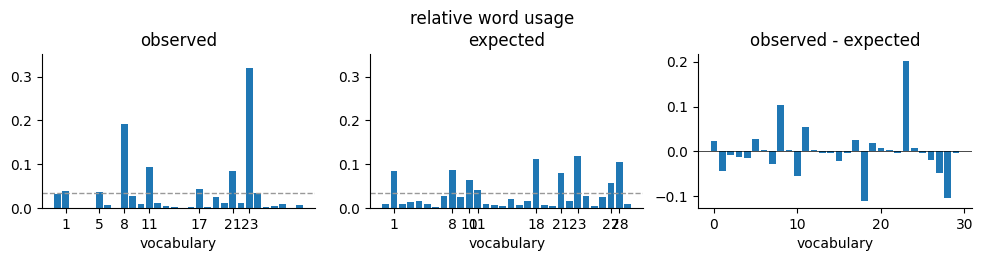

In [75]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,2))

data_rel_usage = data.sum(axis=0) / data.sum()
topics_rel_usage = topics.sum(axis=0) / topics.sum()
ylim = onp.max([data_rel_usage, topics_rel_usage])
for ax, arr, title in zip(axs, [data_rel_usage, topics_rel_usage], ['observed', 'expected']):
    ax.bar(range(vocab_size), arr)
    ax.set_title(title)
    ax.set_xlabel('vocabulary')
    ax.set_ylim(0, 1.1*ylim)

    threshold = 1 / vocab_size
    xticks = onp.nonzero(arr >= threshold)[0]
    ax.set_xticks(xticks); ax.set_xticklabels(xticks)
    ax.axhline(threshold, color='0.6', ls='--', lw=1)

# Show differences in usage
ax = axs[-1]
diff = data_rel_usage - topics_rel_usage
ax.bar(range(vocab_size), diff)

# adjust ylims so that they are not too small
ymin, ymax = ax.get_ylim()
ax.set_ylim(onp.minimum(ymin, -0.1), onp.maximum(ymax, 0.1))

ax.set_title('observed - expected')
ax.set_xlabel('vocabulary')
ax.axhline(0, color='k', lw=0.5)

fig.suptitle('relative word usage', y=1.1)
sns.despine()

The observed relative word usages are now strongly dominated by the associated scaling hyperparameter (i.e. $\alpha_v^{(\gamma)})$.

Text(0.5, 0.95, 'observed word usage')

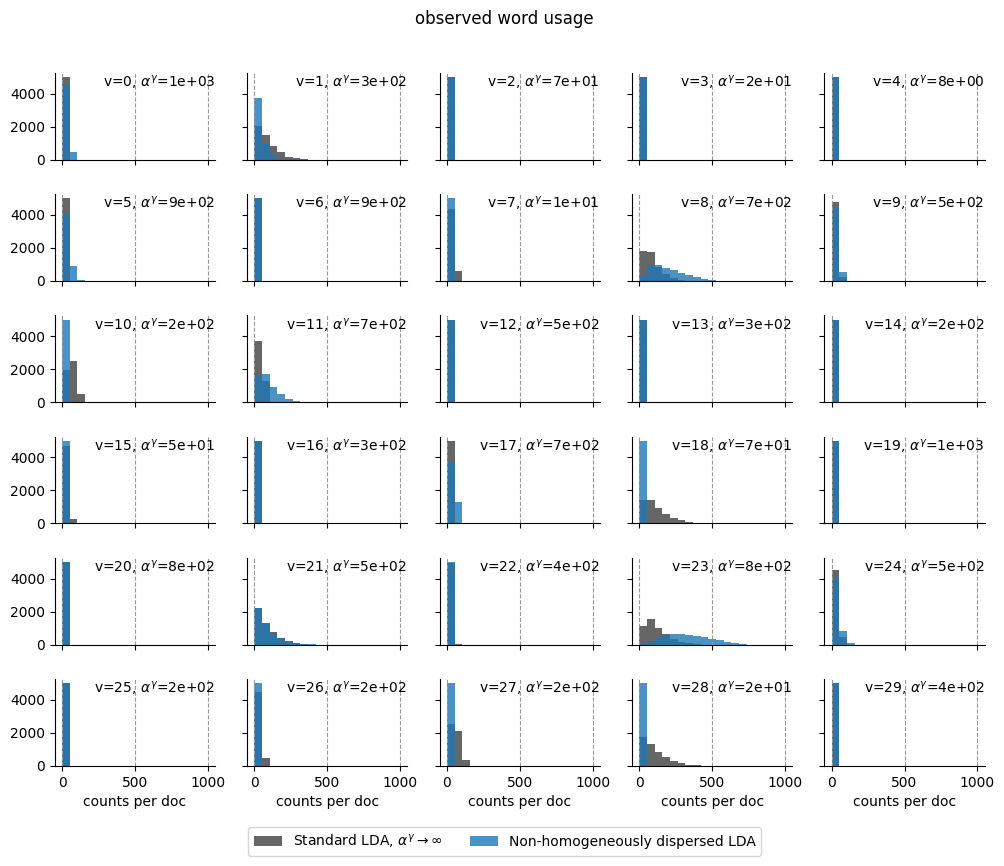

In [76]:
ncols = 5
nrows = (vocab_size // ncols) + (vocab_size % ncols > 0)

# Share bins
n_bins = 20
bin_edges = onp.linspace(0, doc_length_rate, num=n_bins)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(12,9),
    gridspec_kw={'hspace': 0.4},
)

for v, ax in enumerate(axs.ravel()):
    # Plot the data generated from a standard LDA
    ax.hist(
        standard_data[:,v], bin_edges, histtype='stepfilled',
        label=r'Standard LDA, $\alpha^\gamma \rightarrow \infty$',
        color = '0.4'
    )

    # Plot this data
    ax.hist(
        data[:,v], bin_edges, histtype='stepfilled',
        label=r'Non-homogeneously dispersed LDA',
        fc='C0', alpha=0.8
    )

    # Set y-axis to LOG scale so that we can see the heavy tails.
    # ax.set_yscale('log')

    ax.grid(True, axis='x', color='0.6', ls='--')

    ax.text(
        1, 1, rf"{v=}, $\alpha^\gamma$={gamma_shapes[v]:.0e}",
        ha='right', va='top', transform=ax.transAxes
    )

for ax in axs[-1,:]:
    ax.set_xlabel('counts per doc')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], bbox_to_anchor=[0.5, 0.05], loc='upper center', ncols=2)
sns.despine()

fig.suptitle('observed word usage', y=0.95)



In [79]:
n_inits = 2
n_topics = 8

all_topics, all_weights, all_lls = [], [], []
for _ in range(n_inits):
    lda = LDA(n_topics)
    weights = lda.fit_transform(data)
    topics = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
    
    scales = jnp.ones(vocab_size)/vocab_size  # In standard lda model, scales are just uniform 1/V

    lls = multinomial_ll(data, topics, weights, scales).mean()

    all_topics.append(topics)
    all_weights.append(weights)
    all_lls.append(lls)

all_topics = onp.asarray(all_topics)
all_weights = onp.asarray(all_weights)
all_lls = onp.asarray(all_lls)

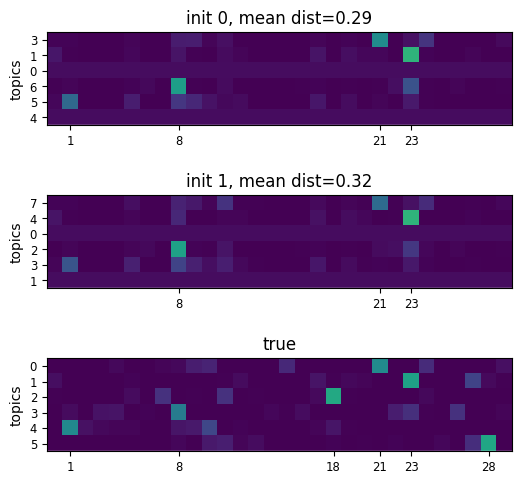

In [80]:
topics_vmax = 1

# fig, axs = plt.subplots(nrows=1, ncols=n_inits+1, figsize=(12,6))
fig, axs = plt.subplots(ncols=1, nrows=n_inits+1, figsize=(6,6))

dict_of_things = {
    **{f"init {i}": all_topics[i] for i in range(n_inits)},
    "true": true_params['topics']
}

for ax, (name, topics) in zip(axs, dict_of_things.items()):
    # Find the best permutation
    if name != "true":
        cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
        _, i_sorted = linear_sum_assignment(cost_matrix)
        i_discarded = onp.nonzero(onp.isin(onp.arange(len(topics)), i_sorted, invert=True))[0]
        # i_permute = onp.concatenate([i_sorted, i_discarded]) # no need to show discarded ones
        i_permute = i_sorted
        
        final_cost = onp.diag(cost_matrix[:,i_sorted]).mean()
        ax.set_title(f"{name}, mean dist={final_cost:.2f}")
    else:
        i_sorted = i_permute = onp.arange(len(topics))
        ax.set_title(name)

    im = ax.imshow(topics[i_permute], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
    
    # Draw line to indicate the topics below which have been discarded
    ax.axhline(len(i_sorted)-0.5, color='w', lw=1)

    # Label topics by their original ordering
    ax.set_yticks(onp.arange(len(i_permute))); ax.set_yticklabels(i_permute)
    
    # Label the words that have "high" weight
    threshold = 10. / vocab_size
    xticks = onp.nonzero(onp.max(topics[i_permute][:len(i_sorted)], axis=0) >= threshold)[0]
    ax.set_xticks(xticks); ax.set_xticklabels(xticks)
    ax.tick_params(labelsize='small')
    # ax.tick_params(bottom=False, labelbottom=False)  # don't show any ticks


    ax.set_ylabel('topics')
    # ax.set_xlabel('vocab')    

### Non-homogenous

<BarContainer object of 30 artists>

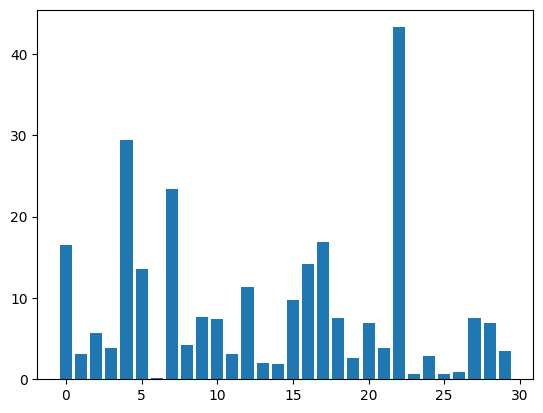

In [100]:
plt.bar(range(vocab_size), jr.gamma(scales_key_0, 1, (vocab_size)) / 1e-1)

In [101]:
scales_key_0, scales_key_1 = jr.split(jr.fold_in(scales_key, 5))
# gamma_shapes = jr.uniform(scales_key_0, (vocab_size,), minval=1e-1, maxval=1e1)
gamma_shapes = jr.gamma(scales_key_0, 1, (vocab_size)) / 1e-1

gammas = gamma_shapes * jr.gamma(scales_key_1, gamma_shapes, (n_docs, vocab_size))

# Topic weights and data
# weights: shape (n_docs, n_topics)
# data: shape (n_docs, vocab_size)
weights, data = sample_weights_and_data(
    weights_and_data_key, topics, gammas, n_docs, doc_length_rate, weights_conc
)

true_params = dict(
    topics = topics, 
    weights = weights,
    gammas = gammas,
)

Text(0.5, 1.0, 'prior scales')

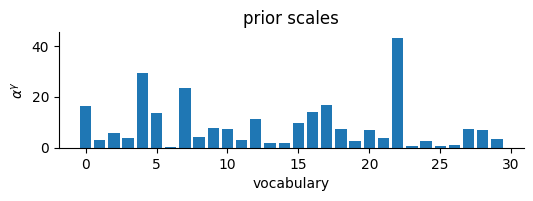

In [102]:
plt.figure(figsize=(6,1.5))

ax = plt.gca()
ax.bar(range(vocab_size), gamma_shapes)
ax.set_ylim(0)
sns.despine()
ax.set_xlabel('vocabulary')
ax.set_ylabel(r'$\alpha^\gamma$')
ax.set_title('prior scales')

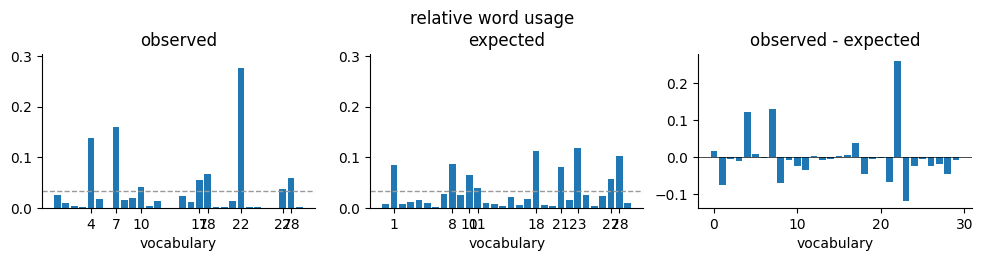

In [103]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,2))

data_rel_usage = data.sum(axis=0) / data.sum()
topics_rel_usage = standard_data.sum(axis=0) / standard_data.sum()
ylim = onp.max([data_rel_usage, topics_rel_usage])
for ax, arr, title in zip(axs, [data_rel_usage, topics_rel_usage], ['observed', 'expected']):
    ax.bar(range(vocab_size), arr)
    ax.set_title(title)
    ax.set_xlabel('vocabulary')
    ax.set_ylim(0, 1.1*ylim)

    threshold = 1 / vocab_size
    xticks = onp.nonzero(arr >= threshold)[0]
    ax.set_xticks(xticks); ax.set_xticklabels(xticks)
    ax.axhline(threshold, color='0.6', ls='--', lw=1)

# Show differences in usage
ax = axs[-1]
diff = data_rel_usage - topics_rel_usage
ax.bar(range(vocab_size), diff)

# adjust ylims so that they are not too small
ymin, ymax = ax.get_ylim()
ax.set_ylim(onp.minimum(ymin, -0.1), onp.maximum(ymax, 0.1))

ax.set_title('observed - expected')
ax.set_xlabel('vocabulary')
ax.axhline(0, color='k', lw=0.5)

fig.suptitle('relative word usage', y=1.1)
sns.despine()

Text(0.5, 0.95, 'observed word usage')

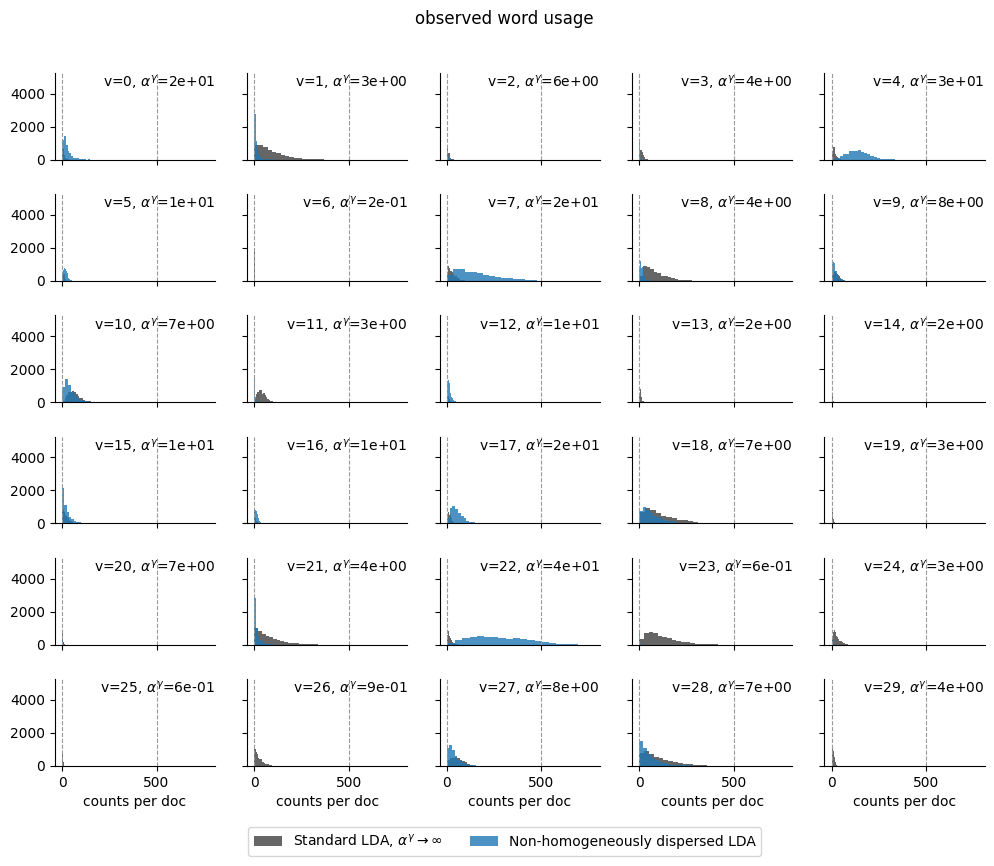

In [108]:
ncols = 5
nrows = (vocab_size // ncols) + (vocab_size % ncols > 0)

# Share bins
# n_bins = 20
# bin_edges = onp.linspace(0, doc_length_rate, num=n_bins)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharey=True, sharex=True, figsize=(12,9),
    gridspec_kw={'hspace': 0.4},
)

for v, ax in enumerate(axs.ravel()):
    # Plot the data generated from a standard LDA
    ax.hist(
        standard_data[:,v], 20, histtype='stepfilled',
        label=r'Standard LDA, $\alpha^\gamma \rightarrow \infty$',
        color = '0.4'
    )

    # Plot this data
    ax.hist(
        data[:,v], 20, histtype='stepfilled',
        label=r'Non-homogeneously dispersed LDA',
        fc='C0', alpha=0.8
    )

    # Set y-axis to LOG scale so that we can see the heavy tails.
    # ax.set_yscale('log')

    ax.grid(True, axis='x', color='0.6', ls='--')

    ax.text(
        1, 1, rf"{v=}, $\alpha^\gamma$={gamma_shapes[v]:.0e}",
        ha='right', va='top', transform=ax.transAxes
    )

for ax in axs[-1,:]:
    ax.set_xlabel('counts per doc')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], bbox_to_anchor=[0.5, 0.05], loc='upper center', ncols=2)
sns.despine()

fig.suptitle('observed word usage', y=0.95)



In [105]:
n_inits = 2
n_topics = 10

all_topics, all_weights, all_lls = [], [], []
for _ in range(n_inits):
    lda = LDA(n_topics)
    weights = lda.fit_transform(data)
    topics = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
    
    scales = jnp.ones(vocab_size)/vocab_size  # In standard lda model, scales are just uniform 1/V

    lls = multinomial_ll(data, topics, weights, scales).mean()

    all_topics.append(topics)
    all_weights.append(weights)
    all_lls.append(lls)

all_topics = onp.asarray(all_topics)
all_weights = onp.asarray(all_weights)
all_lls = onp.asarray(all_lls)

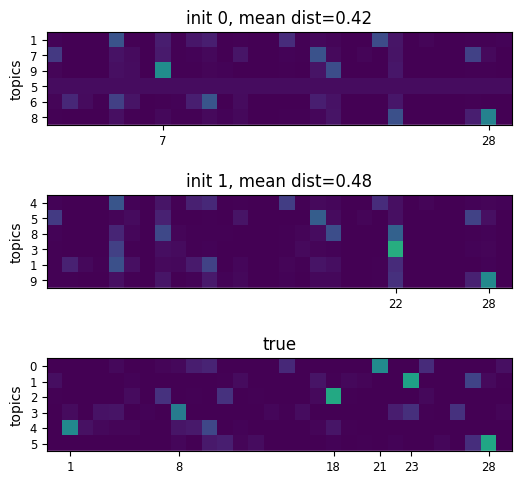

In [106]:
topics_vmax = 1

# fig, axs = plt.subplots(nrows=1, ncols=n_inits+1, figsize=(12,6))
fig, axs = plt.subplots(ncols=1, nrows=n_inits+1, figsize=(6,6))

dict_of_things = {
    **{f"init {i}": all_topics[i] for i in range(n_inits)},
    "true": true_params['topics']
}

for ax, (name, topics) in zip(axs, dict_of_things.items()):
    # Find the best permutation
    if name != "true":
        cost_matrix = cdist(true_params['topics'], topics, metric='cosine')
        _, i_sorted = linear_sum_assignment(cost_matrix)
        i_discarded = onp.nonzero(onp.isin(onp.arange(len(topics)), i_sorted, invert=True))[0]
        # i_permute = onp.concatenate([i_sorted, i_discarded]) # no need to show discarded ones
        i_permute = i_sorted
        
        final_cost = onp.diag(cost_matrix[:,i_sorted]).mean()
        ax.set_title(f"{name}, mean dist={final_cost:.2f}")
    else:
        i_sorted = i_permute = onp.arange(len(topics))
        ax.set_title(name)

    im = ax.imshow(topics[i_permute], vmin=0, vmax=topics_vmax, aspect='equal', interpolation='none')
    
    # Draw line to indicate the topics below which have been discarded
    ax.axhline(len(i_sorted)-0.5, color='w', lw=1)

    # Label topics by their original ordering
    ax.set_yticks(onp.arange(len(i_permute))); ax.set_yticklabels(i_permute)
    
    # Label the words that have "high" weight
    threshold = 10. / vocab_size
    xticks = onp.nonzero(onp.max(topics[i_permute][:len(i_sorted)], axis=0) >= threshold)[0]
    ax.set_xticks(xticks); ax.set_xticklabels(xticks)
    ax.tick_params(labelsize='small')
    # ax.tick_params(bottom=False, labelbottom=False)  # don't show any ticks


    ax.set_ylabel('topics')
    # ax.set_xlabel('vocab')    